# Design a way to impute the missing aft look data due to RFI in US and Europe

In [25]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np

import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__name__), '../..')))

from src.processing import windsat_datacube, create_landmask
wst_path = "../../data/raw/daily_Windsat/"

In [2]:
ds = windsat_datacube(wst_path, look=None)
ds

<xarray.Dataset> Size: 6GB
Dimensions:         (day_number: 24, longitude_grid: 1440, latitude_grid: 720,
                     swath_sector: 2, frequency_band: 2, look_direction: 2,
                     polarization: 2)
Coordinates:
    lat             (latitude_grid) float32 3kB dask.array<chunksize=(720,), meta=np.ndarray>
    lon             (longitude_grid) float32 6kB dask.array<chunksize=(1440,), meta=np.ndarray>
  * day_number      (day_number) int32 96B 1 2 57 58 84 ... 283 323 324 348 349
Dimensions without coordinates: longitude_grid, latitude_grid, swath_sector,
                                frequency_band, look_direction, polarization
Data variables: (12/13)
    longitude       (day_number, longitude_grid) float32 138kB dask.array<chunksize=(1, 1440), meta=np.ndarray>
    latitude        (day_number, latitude_grid) float32 69kB dask.array<chunksize=(1, 720), meta=np.ndarray>
    node            (day_number, swath_sector) int32 192B dask.array<chunksize=(1, 2), meta=np.ndarray>
    frequency_vpol  (day_number, frequency_band) float32 192B dask.array<chunksize=(1, 2), meta=np.ndarray>
    frequency_hpol  (day_number, frequency_band) float32 192B dask.array<chunksize=(1, 2), meta=np.ndarray>
    eia_nominal     (day_number, frequency_band) float32 192B dask.array<chunksize=(1, 2), meta=np.ndarray>
    ...              ...
    eaa             (day_number, frequency_band, latitude_grid, longitude_grid, look_direction, swath_sector) float32 796MB dask.array<chunksize=(1, 1, 360, 720, 1, 1), meta=np.ndarray>
    eia             (day_number, frequency_band, latitude_grid, longitude_grid, look_direction, swath_sector) float32 796MB dask.array<chunksize=(1, 1, 360, 720, 1, 1), meta=np.ndarray>
    tbtoa           (day_number, polarization, frequency_band, latitude_grid, longitude_grid, look_direction, swath_sector) float32 2GB dask.array<chunksize=(1, 1, 1, 240, 480, 1, 1), meta=np.ndarray>
    quality_flag    (day_number, latitude_grid, longitude_grid, look_direction, swath_sector) int32 398MB dask.array<chunksize=(1, 360, 720, 1, 1), meta=np.ndarray>
    surtep_ERA5     (day_number, latitude_grid, longitude_grid, swath_sector) float32 199MB dask.array<chunksize=(1, 360, 720, 1), meta=np.ndarray>
    airtep_ERA5     (day_number, latitude_grid, longitude_grid, swath_sector) float32 199MB dask.array<chunksize=(1, 360, 720, 1), meta=np.ndarray>
Attributes: (12/72)
    Conventions:                            CF-1.7
    title:                                  RSS WindSat TOA Brightness Temper...
    version:                                V01.0
    summary:                                The dataset contains RSS WindSat ...
    references:                              [1] T. Meissner et al., Remote S...
    acknowledgement:                        Funded under NASA Grant 80NSSC21K...
    ...                                     ...
    Source_of_ancillary_IMERG_rain_rate:    Huffman, G. et al.,  2019. NASA G...
    Source_of_ancillary_CCMP_wind:          Mears, C. et al., 2023.Remote Sen...
    Source_of_ancillary_ERA5:               ECMWF Reanalysis v5 (ERA5). https...
    Source_of_RSS_WindSat_AS_ECV:           https://www.remss.com/missions/wi...
    Source_of_ancillary_HYCOM_SSS:          Hybrid Coordinate Ocean Model, Gl...
    Source_of_WindSat_L1C_TB:               T. Meissner et al., Remote Sensin...

In [22]:
# Find all pixels that can be imputed:

""" 
All land pixels, over 2ºC in ERA5 land skin temp., that have look = 1 but do not have look = 0. 
Add a flag to those

The value of TbToA for that will be replaced by the aft look value, (linear reg is very close to Tb(fore) = Tb(aft))
"""

landmask = create_landmask(lon = ds.lon.values, lat=ds.lat.values)
ds["landmask"] = (("latitude_grid","longitude_grid"), landmask.values)

ds = ds.where(ds.landmask == 0)

# Swap grid with lat lon for projected plots:

ds = ds.swap_dims({
    "latitude_grid": "lat",
    "longitude_grid" : "lon"
})

ds = ds.sortby(["lat","lon"])

fore = ds.sel(look_direction = 0)
aft = ds.sel(look_direction = 1)



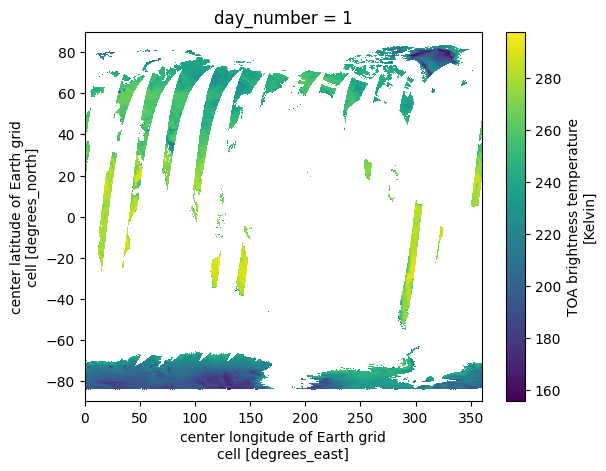

In [23]:
fore.sel(day_number = 1, polarization = 0, frequency_band = 0, swath_sector = 1).tbtoa.plot()

In [24]:
can_impute = aft.where(np.isnan(fore.tbtoa))

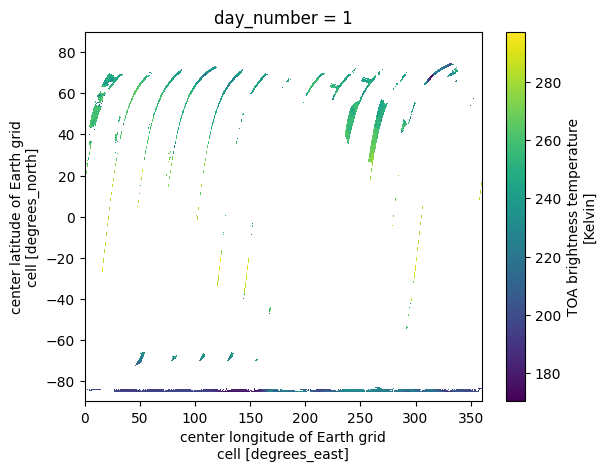

In [26]:
can_impute.sel(day_number = 1, polarization = 0, frequency_band = 0, swath_sector = 1).tbtoa.plot()

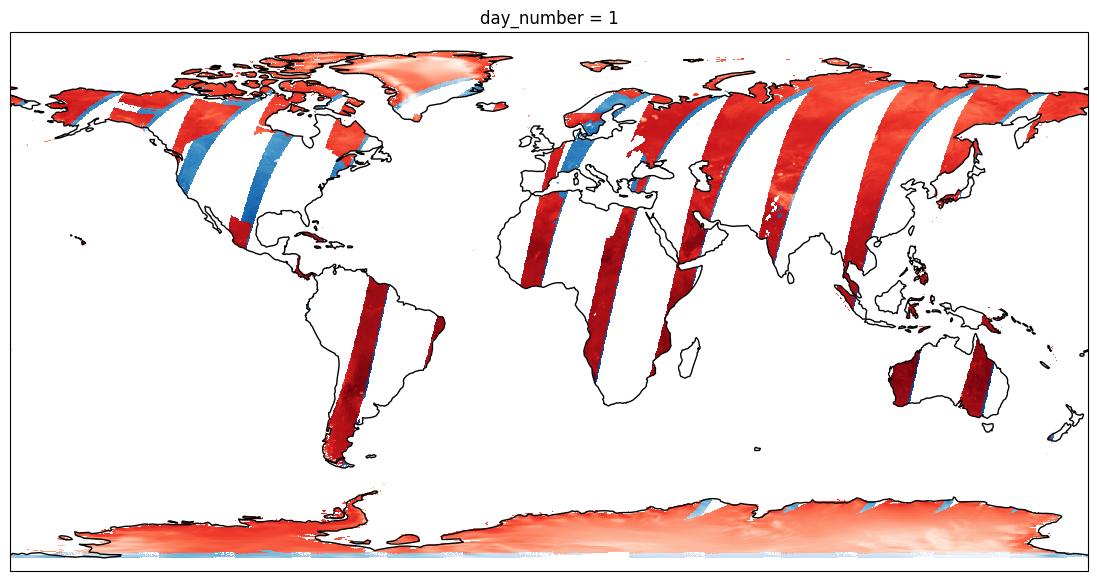

In [28]:
# Plot both looks on top of each other:

fig, ax = plt.subplots(1,1,figsize = (14,7), subplot_kw={"projection": ccrs.PlateCarree()})

plot_kw = {
    "add_colorbar" : False,
    "alpha" : 1
}

can_impute.sel(day_number = 1, polarization = 0, frequency_band = 0, swath_sector = 1).tbtoa.plot(label = "Can impute values",ax= ax, cmap = "Blues",**plot_kw)

fore.sel(day_number = 1, polarization = 0, frequency_band = 0, swath_sector = 1).tbtoa.plot(label = "Has Fore look data",ax=ax, cmap = "Reds",**plot_kw)

ax.coastlines("110m")